In [46]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import h5py

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import os, sys, time, random

from importlib import reload

import fidle

from myutils.dataset import  read_dataset
from myutils.models import get_model_v1

In [47]:
enhanced_dir = './data'

dataset_name  = 'set-24x24-RGB'
batch_size    = 64
epochs        = 40
scale         = 1
fit_verbosity = 1

run_dir ='./'

In [48]:
x_train,y_train,x_test,y_test= read_dataset(enhanced_dir, dataset_name)

# ---- Rescale 
#
x_train,y_train, x_test,y_test = fidle.utils.rescale_dataset(x_train,y_train,x_test,y_test, scale=scale)

(932, 24, 24, 3) (932,)
Datasets have been shuffled.
Datasets have been resized with a factor  1


Callbacks

In [49]:
fidle.utils.mkdir(run_dir + '/models')
fidle.utils.mkdir(run_dir + '/logs')

# ---- Callback tensorboard
log_dir = run_dir + "/logs/tb_" + fidle.Chrono.tag_now()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ---- Callback ModelCheckpoint - Save best model
save_dir = run_dir + "/models/best-model.h5"
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)

# ---- Callback ModelCheckpoint - Save model each epochs
save_dir = run_dir + "/models/model-{epoch:04d}.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0)

path=os.path.abspath(f'{run_dir}/logs')
print(f'To run tensorboard :\ntensorboard --logdir {path}')

To run tensorboard :
tensorboard --logdir /home/20015587/Documents/ING3/DeepL/TP1/resolution/logs


Data generator

In [50]:
datagen = keras.preprocessing.image.ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.)
datagen.fit(x_train)

In [51]:
(n,lx,ly,lz) = x_train.shape
print("Images of the dataset have this folowing shape : ",(lx,ly,lz))

Images of the dataset have this folowing shape :  (24, 24, 3)


In [52]:
model = get_model_v1(lx,ly,lz)

# model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [53]:
chrono=fidle.Chrono()
chrono.start()

history = model.fit(  datagen.flow(x_train, y_train, batch_size=batch_size),
                      steps_per_epoch = int(x_train.shape[0]/batch_size),
                      epochs=epochs,
                      verbose=fit_verbosity,
                      validation_data=(x_test, y_test),
                      callbacks=[tensorboard_callback, bestmodel_callback, savemodel_callback] )

model.save(f'{run_dir}/models/last-model.h5')

chrono.show()

Epoch 1/40


2023-12-11 09:14:53.070316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


14/14 [==============================] - 3s 185ms/step - loss: 3.1174 - accuracy: 0.1348 - val_loss: 2.7922 - val_accuracy: 0.2876
Epoch 2/40
14/14 [==============================] - 3s 217ms/step - loss: 2.7255 - accuracy: 0.2247 - val_loss: 2.5783 - val_accuracy: 0.3305
Epoch 3/40
14/14 [==============================] - 3s 193ms/step - loss: 2.5391 - accuracy: 0.2696 - val_loss: 2.3914 - val_accuracy: 0.3691
Epoch 4/40
14/14 [==============================] - 3s 209ms/step - loss: 2.3568 - accuracy: 0.3283 - val_loss: 2.1841 - val_accuracy: 0.3948
Epoch 5/40
14/14 [==============================] - 3s 176ms/step - loss: 2.1687 - accuracy: 0.3721 - val_loss: 2.0568 - val_accuracy: 0.4034
Epoch 6/40
14/14 [==============================] - 2s 171ms/step - loss: 2.0272 - accuracy: 0.4055 - val_loss: 1.9505 - val_accuracy: 0.4163
Epoch 7/40
14/14 [==============================] - 2s 176ms/step - loss: 1.9807 - accuracy: 0.4124 - val_loss: 1.8820 - val_accuracy: 0.4678
Epoch 8/40
14/14 

In [54]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.7124


In [55]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 1.1380
Test accuracy  : 0.6738


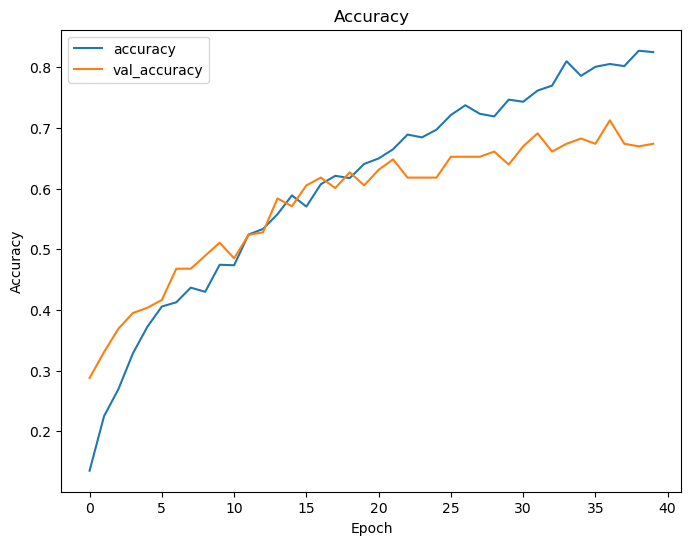

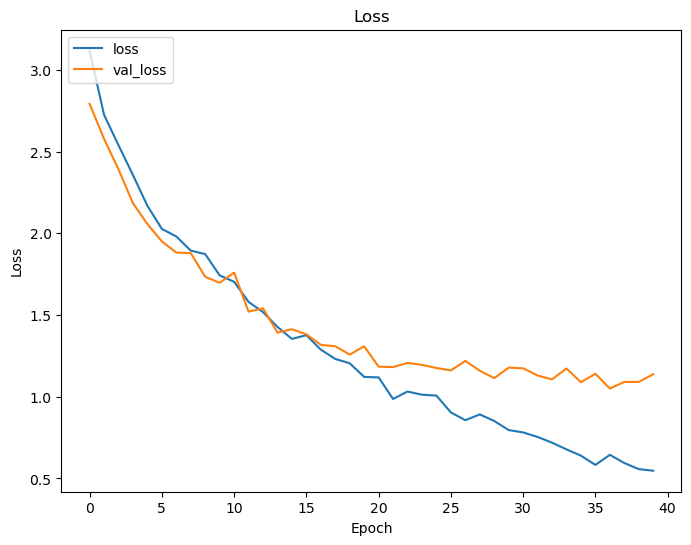

In [56]:
fidle.scrawler.history(history, save_as='01-history')

Evaluate best model

In [57]:
loaded_model = tf.keras.models.load_model(f'{run_dir}/models/best-model.h5')
# best_model.summary()
print("Loaded.")

Loaded.


In [58]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 1.0907
Test accuracy  : 0.6695


8/8 [==============================] - 0s 29ms/step


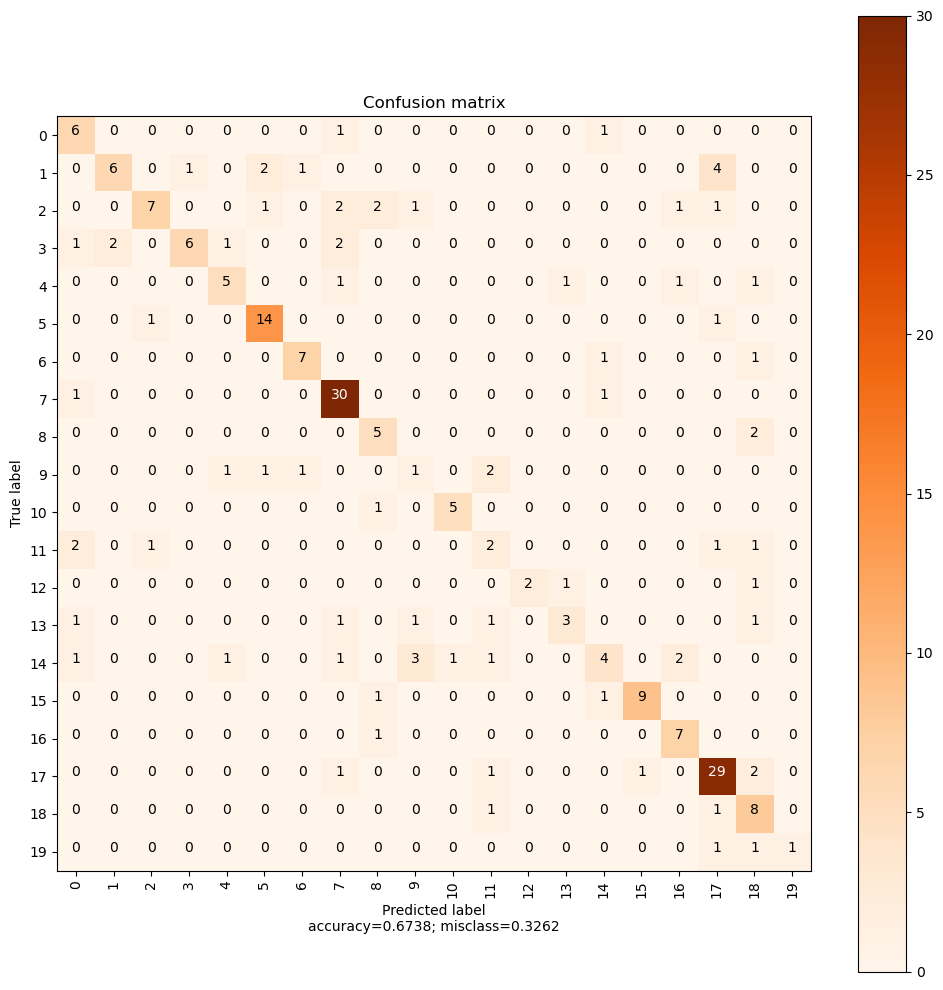

In [59]:
y_sigmoid = model.predict(x_test)
y_pred    = np.argmax(y_sigmoid, axis=-1)

cmap = plt.get_cmap('Oranges')
fidle.scrawler.confusion_matrix(y_test,y_pred,range(20), figsize=(10, 10),normalize=False, cmap=cmap, save_as='02-confusion-matrix')